In [1]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn import metrics
import sklearn
from keras.models import Sequential
from keras.layers import Dense,Conv1D, Activation, Dropout, MaxPooling1D, Flatten, BatchNormalization
import keras
from tqdm.notebook import trange, tqdm
from joblib import dump,load # save & load model
from keras.models import load_model
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
import tensorflow as tf
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
emotions=['Neutral', 'Angry', 'Happy', 'Sad', 'Frustrated']

In [3]:
impro_odd  = [1, 3, 4, 2, 5, 3, 4, 5, 1, 2, 5, 3, 1, 2, 4]
impro_even = [2, 3, 1, 5, 4, 3, 5, 1, 4, 2, 5, 4, 3, 1, 2]

In [4]:
print('The librosa version is {}.'.format(librosa.__version__))

The librosa version is 0.7.2.


In [79]:
lis = ['s001_clip_actor001_script1_1_1b','s001_clip_actor001_script1_1_2b','s001_clip_actor001_script1_1_3b','s001_clip_actor001_script1_1_4b','s001_clip_actor001_script1_1_5b']

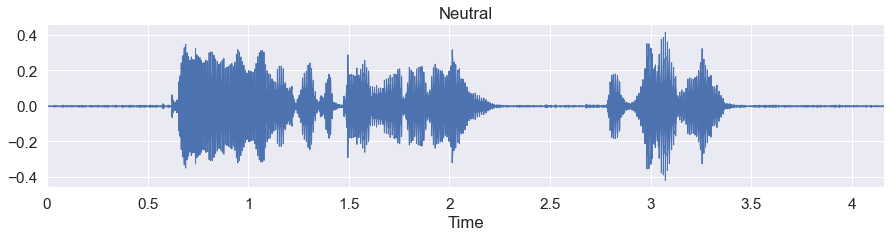

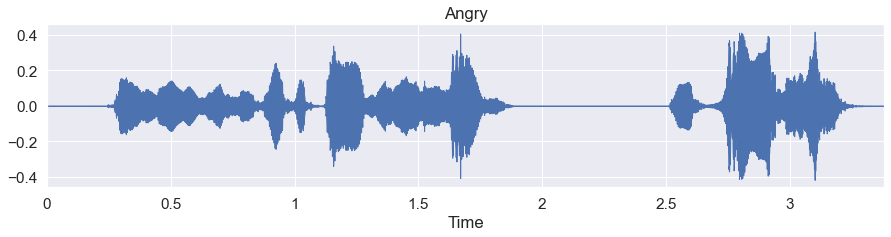

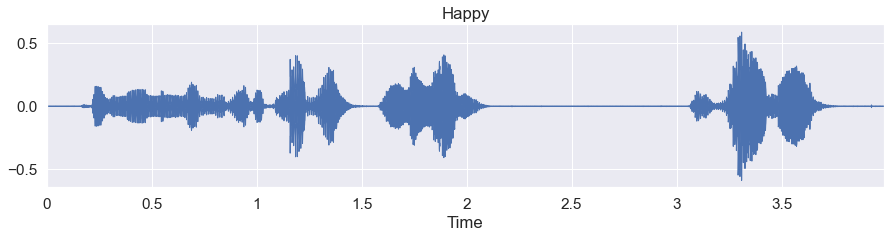

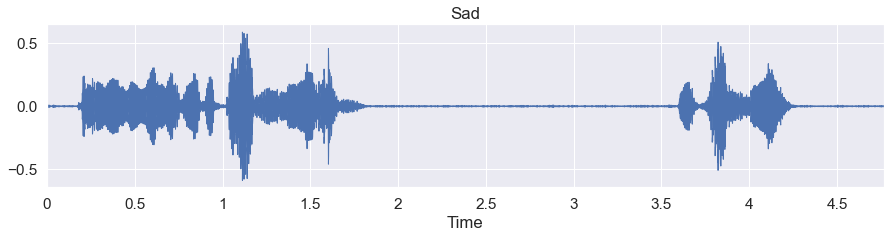

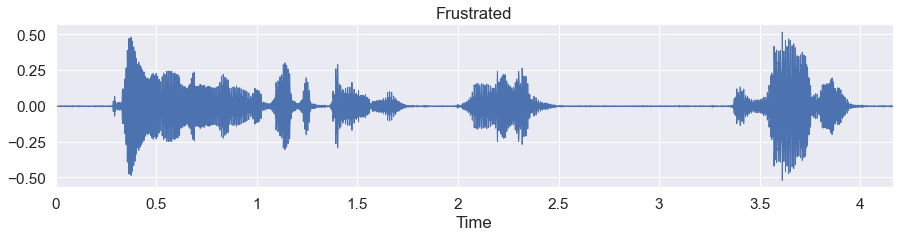

In [80]:
for index, i in enumerate(lis):
    y, sr = librosa.load('dataset/script/'+i+'.flac')
    plt.figure(figsize = (15, 3))
    librosa.display.waveplot(y, sr=sr)
    plt.title(emotions[index])

## Feature Extraction
<ol>
    <li>Mfcc: Mel-frequency cepstral coefficients (40 Features)</li>
    <li>Chroma-stft: Compute a chromagram from a waveform or power spectrogram (12 Features)</li>
    <li>Melspectrogram: Compute a Mel-scaled power spectrogram (128 Features)</li>
    <li>Spectral contrast: Compute spectral contrast (7 Features)</li>
    <li>Tonnetz: Computes the tonal centroid features (6 Features)</li>
</ol>

In [4]:
def extract_feature(file_name): 
    X, sample_rate = librosa.load(file_name)
    result=np.array([])
    stft = np.abs(librosa.stft(X))
    
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    result=np.hstack((result, mfccs))
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, chroma))
    
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result=np.hstack((result, mel))
    
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    result=np.hstack((result, contrast))
    
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    result=np.hstack((result, tonnetz))
    return result

## Collect Data (Script Session)

In [5]:
#x,y=[],[]
data = []
for file in glob.glob("dataset/script/*.flac"):
    base=os.path.basename(file)
    file_name=os.path.splitext(base)
    emotion=int(file_name[0].split("_")[-1][0])    
    feature=extract_feature(file)
    fe = np.hstack((feature, emotion))
    data.append(fe)
    #x.append(feature)
    #y.append(emotion)

In [6]:
df = pd.DataFrame(data)

In [8]:
df.shape

(21562, 194)

In [15]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-373.585815,154.361542,24.368185,12.183940,6.071077,-7.654665,-7.128195,-2.588730,-0.672319,6.745025,...,17.443085,17.436639,30.155380,-0.006983,0.016132,-0.007108,0.059371,0.009088,0.003940,1.0
1,-395.633148,147.347809,28.258036,7.321930,5.511144,-1.676095,-4.916813,-1.790259,-0.008186,8.116653,...,17.106198,16.759955,30.155497,0.007353,0.023714,0.027180,0.036496,0.008675,0.005599,1.0
2,-387.292664,118.132683,-14.674298,-3.195550,1.760867,-18.666378,-13.493925,-8.549674,-11.797532,4.116887,...,18.445393,20.588309,31.447996,-0.009732,0.013267,-0.002341,0.005402,0.005256,0.005305,2.0
3,-384.837036,94.769989,-20.472324,-2.652570,-2.662994,-20.229143,-14.178094,-7.200514,-15.426341,2.592718,...,18.291863,21.411020,31.672662,-0.004905,0.009690,0.042693,0.015859,-0.008463,0.004468,2.0
4,-398.500946,144.877335,14.372167,8.226257,7.917519,-3.599344,-6.540555,-1.812706,-1.538293,9.222363,...,17.564438,17.211560,30.463118,-0.003084,0.012811,-0.017552,0.034028,0.011939,-0.000265,3.0


In [21]:
#df.to_csv("dataset/script.csv", index = False)
#df_script_shuffled = df.sample(frac=1).reset_index(drop=True)
#df_script_shuffled.to_csv("dataset/script_shuffled.csv", index = False)

In [38]:
df_script_shuffled = pd.read_csv('dataset/script_shuffled.csv')

In [39]:
df_script_shuffled.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-407.507812,60.238911,-32.409782,-1.068640,-25.040350,-21.950687,-17.516024,-17.437305,-11.721647,3.160125,...,19.827854,21.928556,34.298307,0.005353,-0.004571,0.018704,-0.003480,-0.002425,0.000142,4.0
1,-287.763336,120.574142,4.119876,33.396130,1.750837,5.842964,-3.622371,-10.545238,2.505137,6.306121,...,19.013526,18.124622,29.848160,-0.008988,0.018264,0.004584,0.015841,-0.004482,-0.011069,1.0
2,-350.682251,108.276649,7.261237,33.013882,13.882632,0.043448,-0.899103,4.851263,-13.631552,4.941274,...,17.390406,18.696361,32.283306,0.001348,-0.009638,-0.052292,-0.032412,0.008656,-0.001188,3.0
3,-352.519470,164.339386,11.029421,-3.042166,5.346539,2.853782,-8.662233,10.200555,0.283229,1.444397,...,18.669160,16.047573,31.759639,-0.003712,0.023600,-0.003344,0.020887,0.014002,0.006441,1.0
4,-357.367920,151.817200,-3.648481,7.437247,11.822708,-6.827237,5.383746,-4.420805,9.366909,5.201176,...,19.052146,18.542304,29.256448,0.002861,0.024289,-0.045213,0.053318,0.008055,-0.006066,5.0


## Collect Data (Improvisation Session)

In [7]:
data = []
for file in tqdm(glob.glob("dataset/impro/*.flac")):
    base=os.path.basename(file)
    file_name=os.path.splitext(base)
    lis=file_name[0].split("_")[2:4]
    if int(lis[0][5:]) % 2 == 0:
        emotion = impro_even
    else:
        emotion = impro_odd
    feature=extract_feature(file)
    fe = np.hstack((feature, emotion[int(lis[1][5:])-1]))
    data.append(fe)

  0%|          | 0/40410 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame(data)

In [9]:
df.shape

(40410, 194)

In [10]:
df.to_csv("dataset/impro.csv", index = False)

In [36]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)
df_shuffled.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-304.505829,72.505363,-35.249092,7.414766,-16.526682,-0.145940,-10.663815,-5.135681,-12.907050,6.753515,...,20.169448,19.527768,34.478135,-0.008103,0.002417,0.005464,0.017728,0.000167,0.000358,2.0
1,-197.121521,144.139923,-8.411032,33.606091,-12.107153,14.191064,3.617882,5.559124,2.156602,5.481736,...,16.031615,17.495243,32.818419,-0.034255,-0.003779,-0.009184,0.090202,-0.012930,-0.013702,5.0
2,-247.379593,129.678497,-7.239680,28.646725,-3.601930,-3.187505,2.883043,2.939030,3.195879,10.245824,...,17.724940,19.653267,32.127201,-0.011385,0.018987,0.040846,-0.007630,0.022323,-0.017139,1.0
3,-280.146881,135.583237,-19.515261,25.800051,6.718574,1.719839,3.066625,-4.901222,4.403074,10.251142,...,19.307114,21.720570,30.994956,0.017708,0.018990,-0.043630,-0.022740,-0.004291,-0.021504,5.0
4,-374.911102,133.683853,-1.997023,9.769372,-1.943128,-21.926382,-1.225701,0.657336,-17.602142,-8.921105,...,16.947770,21.057042,32.456369,-0.011115,0.012688,0.025593,0.014387,0.009846,0.014964,2.0


In [37]:
df_shuffled.to_csv("dataset/impro_shuffled.csv", index = False)

In [66]:
df_impro_shuffled = pd.read_csv('dataset/impro_shuffled.csv')

In [68]:
df_impro_shuffled.shape

(40410, 194)

In [72]:
combined_csv = pd.concat([df_script_shuffled, df_impro_shuffled])

In [73]:
combined_csv.shape

(61972, 194)

In [79]:
combined_csv_shuffled = combined_csv.sample(frac=1).reset_index(drop=True)
combined_csv_shuffled.head()

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,-312.472473,134.034317,-9.788390,28.489447,10.673104,-1.522052,0.595058,0.810369,-4.043458,-3.708929,...,18.063723,17.389653,27.447786,-0.001232,0.001578,-0.029766,0.004539,0.001486,-0.003786,5.0
1,-245.095200,130.143982,-2.553149,36.246441,6.611243,10.597887,1.403724,4.951823,-2.668828,7.254027,...,17.835887,18.849398,33.677309,0.010104,-0.001605,0.048579,-0.052781,0.011775,0.014771,2.0
2,-258.085907,164.110336,-10.361943,40.473900,8.143176,16.842766,6.987494,7.591063,3.777230,8.029146,...,17.253371,19.458966,30.102360,0.011490,-0.014829,0.101344,0.001979,0.029894,-0.003305,4.0
3,-339.483704,152.050293,-21.561899,14.696821,12.685523,-9.154984,-3.829981,4.285148,-0.242300,-1.127125,...,17.591238,18.742101,30.171510,0.004004,0.012657,-0.005531,-0.001877,0.012196,0.005687,5.0
4,-326.659332,125.793884,-36.988319,6.835596,-13.404609,-12.430190,12.204004,-11.261870,1.275913,8.642873,...,20.129127,24.523761,30.113915,-0.001237,0.000349,-0.017357,-0.000058,0.021777,0.013631,3.0


In [80]:
combined_csv_shuffled.to_csv("dataset/combined_shuffled.csv", index = False)

## Preprocessing

In [5]:
df = pd.read_csv('dataset/combined_shuffled.csv')

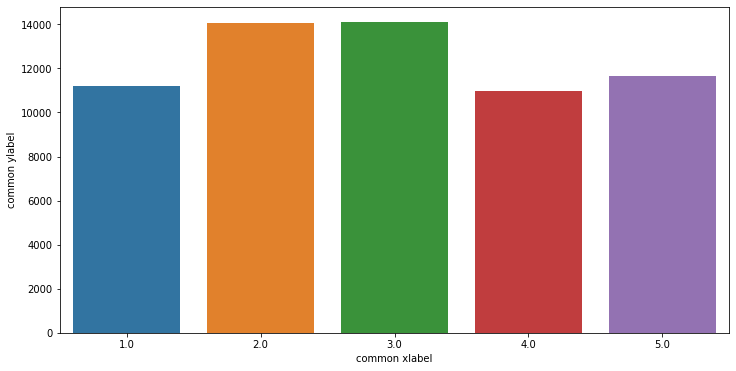

In [6]:
plt.figure(figsize=(12,6))
s1 = sns.countplot(x='193', data=df).set(xlabel='common xlabel', ylabel='common ylabel')

In [7]:
X = df.iloc[:, :193]
y = df.iloc[:,193]

In [8]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,-312.472473,134.034317,-9.788390,28.489447,10.673104,-1.522052,0.595058,0.810369,-4.043458,-3.708929,...,18.003180,18.063723,17.389653,27.447786,-0.001232,0.001578,-0.029766,0.004539,0.001486,-0.003786
1,-245.095200,130.143982,-2.553149,36.246441,6.611243,10.597887,1.403724,4.951823,-2.668828,7.254027,...,16.271029,17.835887,18.849398,33.677309,0.010104,-0.001605,0.048579,-0.052781,0.011775,0.014771
2,-258.085907,164.110336,-10.361943,40.473900,8.143176,16.842766,6.987494,7.591063,3.777230,8.029146,...,14.958639,17.253371,19.458966,30.102360,0.011490,-0.014829,0.101344,0.001979,0.029894,-0.003305
3,-339.483704,152.050293,-21.561899,14.696821,12.685523,-9.154984,-3.829981,4.285148,-0.242300,-1.127125,...,16.777692,17.591238,18.742101,30.171510,0.004004,0.012657,-0.005531,-0.001877,0.012196,0.005687
4,-326.659332,125.793884,-36.988319,6.835596,-13.404609,-12.430190,12.204004,-11.261870,1.275913,8.642873,...,20.135773,20.129127,24.523761,30.113915,-0.001237,0.000349,-0.017357,-0.000058,0.021777,0.013631


In [9]:
y.head()

0    5.0
1    2.0
2    4.0
3    5.0
4    3.0
Name: 193, dtype: float64

In [10]:
le = preprocessing.LabelEncoder()
le.fit(y)

LabelEncoder()

In [11]:
y_le = le.transform(y)

In [12]:
y_le

array([4, 1, 3, ..., 2, 2, 2], dtype=int64)

## Split Train & Test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y_le, test_size =0.2, random_state = 11 )

In [14]:
y_le.shape

(61972,)

In [15]:
print('y_total:')
unique, counts = np.unique(y_le, return_counts=True)
print(dict(zip(unique, counts)))
print('y_train:')
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
print('y_test:')
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

y_total:
{0: 11188, 1: 14074, 2: 14098, 3: 10952, 4: 11660}
y_train:
{0: 9013, 1: 11213, 2: 11252, 3: 8789, 4: 9310}
y_test:
{0: 2175, 1: 2861, 2: 2846, 3: 2163, 4: 2350}


In [17]:
df_y_train = pd.DataFrame(y_train)

<AxesSubplot:xlabel='0', ylabel='count'>

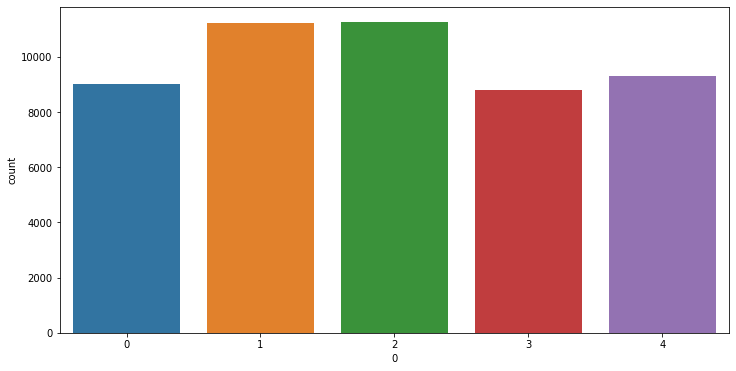

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(x = 0 , data=df_y_train)

<AxesSubplot:xlabel='0', ylabel='count'>

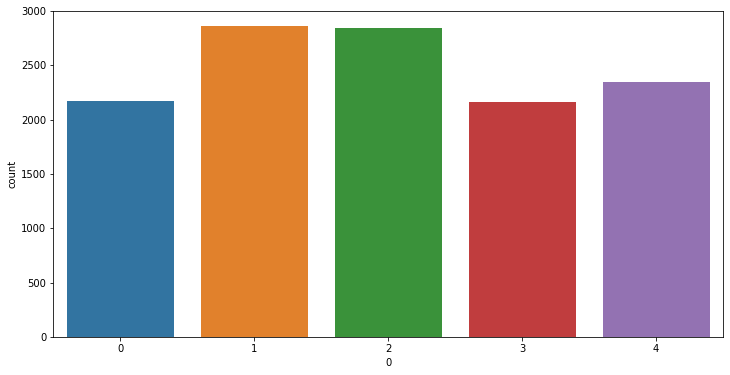

In [19]:
df_y_test = pd.DataFrame(y_test)
plt.figure(figsize=(12,6))
sns.countplot(x = 0 , data=df_y_test)

## SVM

In [61]:
clf_svm = svm.SVC(decision_function_shape='ovr', gamma ='auto') 
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

In [62]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

Accuracy: 0.5206938281565148


In [ ]:
clf_svm = load('model/clf_svm_combined.joblib')
y_pred_svm = clf_svm.predict(X_test)

ROC AUC score (SVM): 0.6918498882257607


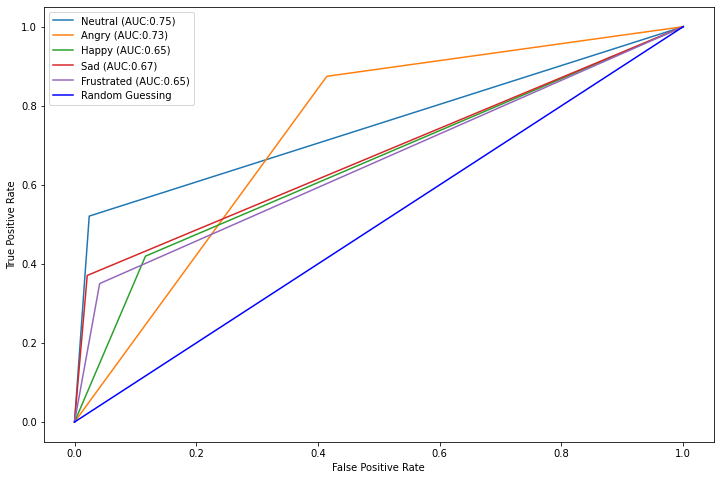

In [65]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score (SVM):', multiclass_roc_auc_score(y_test, y_pred_svm))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [63]:
dump(clf_svm, 'model/clf_svm_combined.joblib')  

['model/clf_svm_combined.joblib']

## Random Forest

In [66]:
clf_rf = RandomForestClassifier(criterion = 'entropy', n_estimators  = 100)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [77]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.5881403791851553


ROC AUC score (RF): 0.7413744428911525


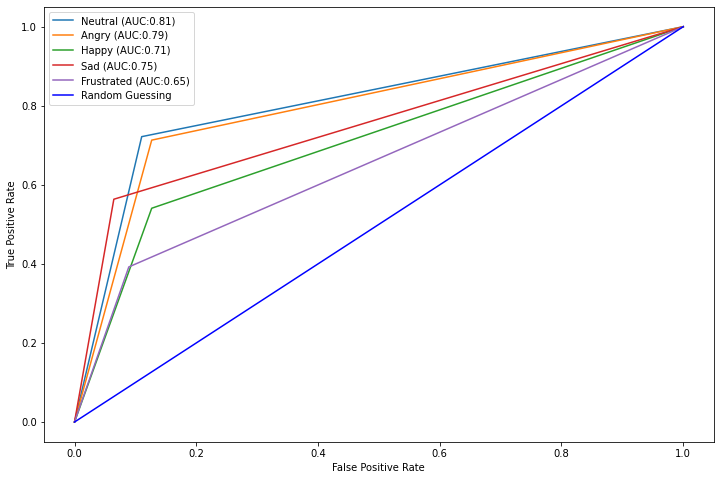

In [78]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

y_pred_mlp = best_model.predict(X_test)
y_pred_mlp = y_pred_mlp.argmax(axis=-1)
print('ROC AUC score (RF):', multiclass_roc_auc_score(y_test, y_pred_rf))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [20]:
dump(clf_rf, 'model/clf_rf_combined.joblib')  

['model/clf_rf_combined.joblib']

## Gradient boosting

In [31]:
clf_gb = GradientBoostingClassifier()
clf_gb.fit(X_train, y_train)
y_pred_gb = clf_gb.predict(X_test)

In [32]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gb))

Accuracy: 0.518676885841065


In [34]:
dump(clf_gb, 'model/clf_gb_combined.joblib')  

['model/clf_gb_combined.joblib']

## MLP

In [15]:
model = Sequential()
model.add(Dense(units = 386, kernel_initializer = 'uniform', activation = 'relu', input_dim = 193))
model.add(Dense(units = 257, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 171, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dense(units = 32, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax'))

In [16]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 386)               74884     
_________________________________________________________________
dense_1 (Dense)              (None, 257)               99459     
_________________________________________________________________
dense_2 (Dense)              (None, 171)               44118     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 860       
Total params: 219,321
Trainable params: 219,321
Non-trainable params: 0
_________________________________________________________________


In [25]:
y_train_ohe = keras.utils.to_categorical(y_train, 5)
y_test_ohe = keras.utils.to_categorical(y_test, 5)

In [301]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-1f6e482f-2053-a9f6-b7ed-5888013cd4db)


In [302]:
print( f"Detected GPU(s): {tf.config.experimental.list_physical_devices('GPU')}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}\n" )

Detected GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.keras.backend.image_data_format() = channels_last



In [19]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_ser_14.hdf5', save_best_only=True, monitor="val_accuracy", mode='max', save_weights_only=False)  

In [20]:
hist = model.fit ( X_train, y_train_ohe, validation_data=(X_test,y_test_ohe), batch_size=64, epochs=50, callbacks=[checkpoint] )

Epoch 1/50
775/775 [==============================] - 4s 4ms/step - loss: 1.3405 - accuracy: 0.4059 - val_loss: 1.2177 - val_accuracy: 0.4841
Epoch 2/50
775/775 [==============================] - 2s 3ms/step - loss: 1.1854 - accuracy: 0.4958 - val_loss: 1.1488 - val_accuracy: 0.5188
Epoch 3/50
775/775 [==============================] - 2s 3ms/step - loss: 1.1236 - accuracy: 0.5285 - val_loss: 1.1059 - val_accuracy: 0.5316
Epoch 4/50
775/775 [==============================] - 2s 3ms/step - loss: 1.0841 - accuracy: 0.5490 - val_loss: 1.0835 - val_accuracy: 0.5502
Epoch 5/50
775/775 [==============================] - 2s 3ms/step - loss: 1.0461 - accuracy: 0.5678 - val_loss: 1.0631 - val_accuracy: 0.5614
Epoch 6/50
775/775 [==============================] - 2s 3ms/step - loss: 1.0042 - accuracy: 0.5810 - val_loss: 1.0553 - val_accuracy: 0.5633
Epoch 7/50
775/775 [==============================] - 2s 3ms/step - loss: 0.9647 - accuracy: 0.6004 - val_loss: 1.0317 - val_accuracy: 0.5728
Epoch 

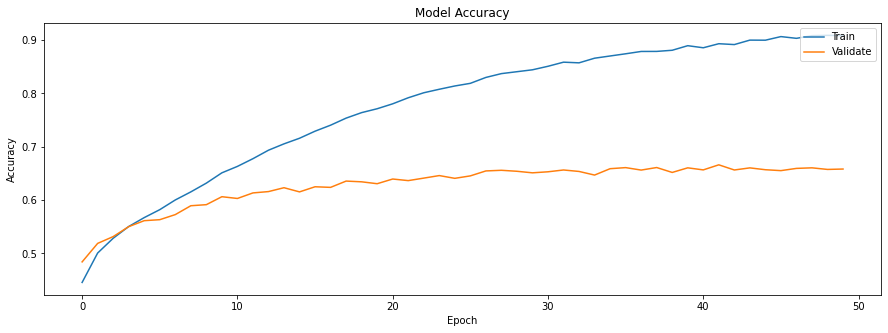

In [21]:
plt.figure(figsize=(15,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

In [52]:
# Evaluate the model from the last epoch
score = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Model from the last epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Load and evaluate the model from the best epoch
best_model = load_model('model/model_ser_14.hdf5', compile=True )
score = best_model.evaluate(X_test, y_test_ohe, verbose=0)
print('Model from the best epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model from the last epoch:
Test loss: 1.7758262157440186
Test accuracy: 0.6582493185997009
Model from the best epoch:
Test loss: 1.5309237241744995
Test accuracy: 0.6661556959152222


ROC AUC score (MLP): 0.7910878631686835


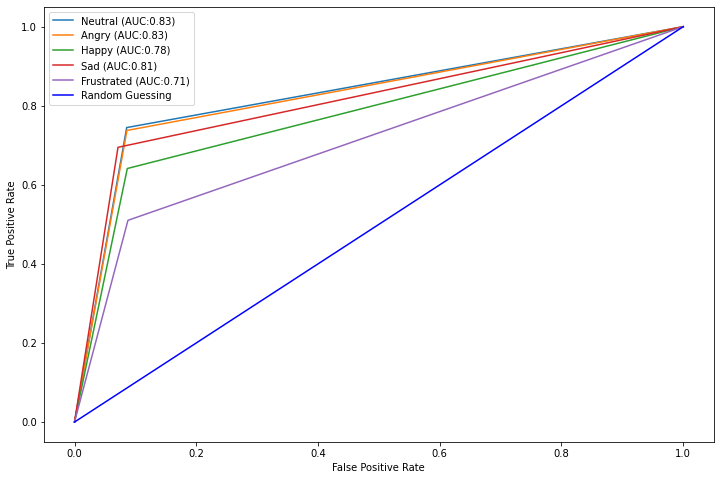

In [53]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

y_pred_mlp = best_model.predict(X_test)
y_pred_mlp = y_pred_mlp.argmax(axis=-1)
print('ROC AUC score (MLP):', multiclass_roc_auc_score(y_test, y_pred_mlp))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
best_model = load_model('model/model_ser_02.hdf5', compile=True )

In [24]:

test = extract_feature('dataset/impro/s044_clip_actor127_impro8_15.flac')
prediction = best_model.predict([test.tolist()])
maxindex = int(np.argmax(prediction))
print(emotions[maxindex])

Frustrated


## Normalization

In [20]:
sc = StandardScaler()

In [20]:
X_train_normalized = sc.fit_transform(X_train)

In [21]:
X_test_normalized = sc.transform(X_test)

In [324]:
#dump(sc, 'model/sc.joblib')  

['model/sc.joblib']

In [5]:
sc = load('model/sc.joblib')

In [22]:
X_train_normalized = sc.transform(X_train)
X_test_normalized = sc.transform(X_test)

In [23]:
df_x = pd.DataFrame(X_train)
df_x.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
48439,-305.367188,138.623932,-63.747673,15.381488,-1.437324,-34.344006,-1.990874,-21.675016,-7.304956,3.809168,...,19.329583,20.353505,31.260382,30.686179,-0.014110,0.000351,-0.024056,0.020476,-0.002631,-0.007812
57907,-350.283997,99.110039,-62.249210,26.445133,12.471749,-2.286218,1.808994,-8.682839,4.519478,18.172131,...,22.976068,24.791019,29.301469,31.166203,-0.011558,-0.005730,-0.062044,-0.031701,0.023634,0.021802
37026,-317.364899,131.888245,16.755302,23.814047,2.077857,-1.086587,-3.186949,16.298677,-10.590102,-1.079978,...,17.926623,18.534106,17.893357,31.017865,0.010069,-0.002967,-0.034040,0.006532,0.018135,-0.009269
54932,-352.677185,152.508484,26.090092,2.565912,-0.487709,-6.322002,-17.487137,6.638436,-1.678195,-9.994580,...,18.778876,19.268306,16.970988,33.891550,0.005604,-0.001544,-0.009224,0.017899,0.008081,0.002091
39550,-286.836609,135.962128,1.872271,29.210138,2.939136,8.199178,16.690832,4.031332,-2.219998,10.879871,...,16.929746,17.506274,20.221352,33.309130,-0.013833,0.012647,-0.033409,0.050928,-0.005354,-0.022370


In [24]:
df_x_nrm = pd.DataFrame(X_train_normalized)
df_x_nrm.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,0.265979,0.392380,-2.388726,-0.107580,-0.159043,-2.535224,-0.034818,-2.569022,-0.206249,-0.031251,...,0.551455,0.917868,4.065433,-0.539742,-1.264078,-0.622162,-0.424276,0.291418,-0.967212,-0.524179
1,-0.643933,-1.086576,-2.318556,0.639774,0.863613,0.066603,0.333468,-1.093970,1.169631,2.049541,...,2.213082,3.321462,3.352983,-0.329091,-1.015005,-1.104701,-1.280244,-1.085781,1.163709,1.695869
2,0.022933,0.140271,1.381061,0.462043,0.099409,0.163965,-0.150742,1.742280,-0.588505,-0.739552,...,-0.087844,-0.067615,-0.796110,-0.394187,1.095675,-0.885453,-0.649239,-0.076644,0.717509,-0.633388
3,-0.692414,0.912061,1.818190,-0.973277,-0.089223,-0.260944,-1.536727,0.645515,0.448475,-2.031029,...,0.300510,0.330067,-1.131573,0.866884,0.659917,-0.772510,-0.090090,0.223380,-0.098101,0.218241
4,0.641367,0.292752,0.684120,0.826551,0.162734,0.917603,1.775827,0.349520,0.385432,0.993096,...,-0.542100,-0.624343,0.050574,0.611298,-1.236952,0.353369,-0.635015,1.095158,-1.188078,-1.615585


## SVM (Normalized)

In [58]:
clf_svm_nrm = svm.SVC(decision_function_shape='ovr', gamma ='scale') 
clf_svm_nrm.fit(X_train_normalized, y_train)
y_pred_svm = clf_svm_nrm.predict(X_test_normalized)

In [59]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

Accuracy: 0.6188785800726099


In [57]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

Accuracy: 0.6188785800726099


In [36]:
clf_svm_nrm = load('model/clf_svm_nrm.joblib')
y_pred_svm = clf_svm_nrm.predict(X_test_normalized)

ROC AUC score (SVM-Normalized): 0.7597554274847294


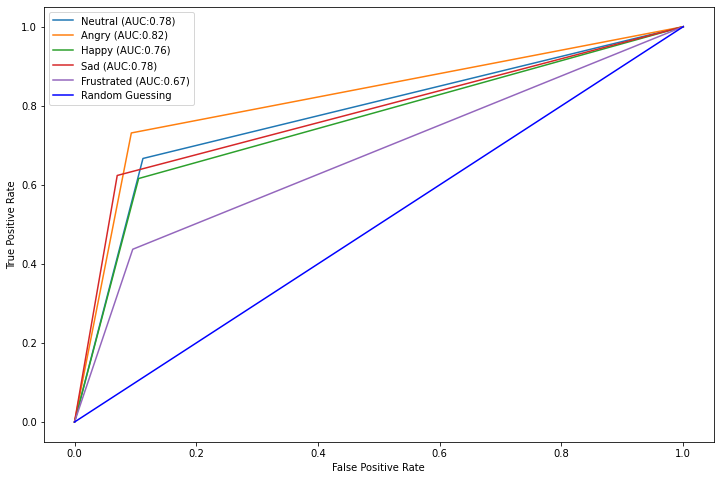

In [60]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)


print('ROC AUC score (SVM-Normalized):', multiclass_roc_auc_score(y_test, y_pred_svm))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

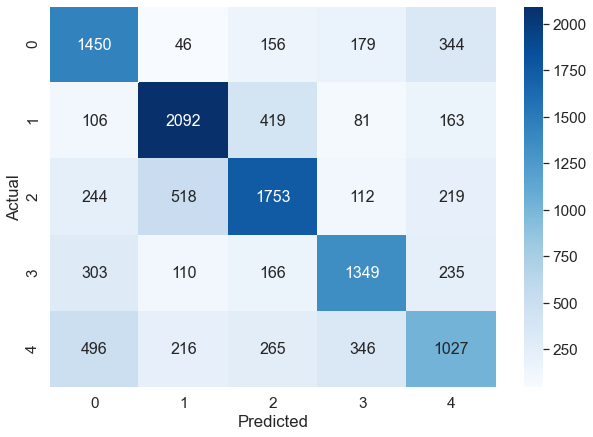

In [71]:
d = metrics.confusion_matrix(y_test, y_pred_svm)
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

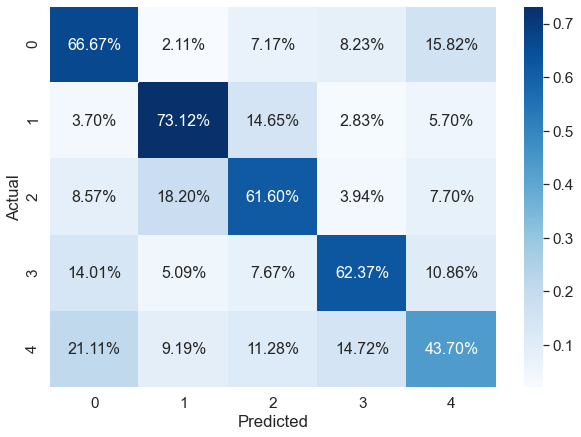

In [72]:
d = metrics.confusion_matrix(y_test, y_pred_svm,normalize = 'true')
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2%')# font size

In [37]:
print(classification_report(y_test, y_pred_svm, target_names=emotions))

              precision    recall  f1-score   support

     Neutral       0.56      0.67      0.61      2175
       Angry       0.70      0.73      0.72      2861
       Happy       0.64      0.62      0.63      2846
         Sad       0.65      0.62      0.64      2163
  Frustrated       0.52      0.44      0.47      2350

    accuracy                           0.62     12395
   macro avg       0.61      0.61      0.61     12395
weighted avg       0.62      0.62      0.62     12395



In [323]:
dump(clf_svm_nrm, 'model/clf_svm_nrm.joblib')  

['model/clf_svm_nrm.joblib']

## RandomForest (Normalized)

In [325]:
clf_rf_nrm = RandomForestClassifier(criterion = 'entropy', n_estimators  = 100)
clf_rf_nrm.fit(X_train_normalized, y_train)
y_pred_rf = clf_rf_nrm.predict(X_test_normalized)

In [26]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.5888664784187172


In [327]:
dump(clf_rf_nrm, 'model/clf_rf_nrm.joblib')  

['model/clf_rf_nrm.joblib']

In [25]:
clf_rf_nrm = load('model/clf_rf_nrm.joblib')
y_pred_rf = clf_rf_nrm.predict(X_test_normalized)

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

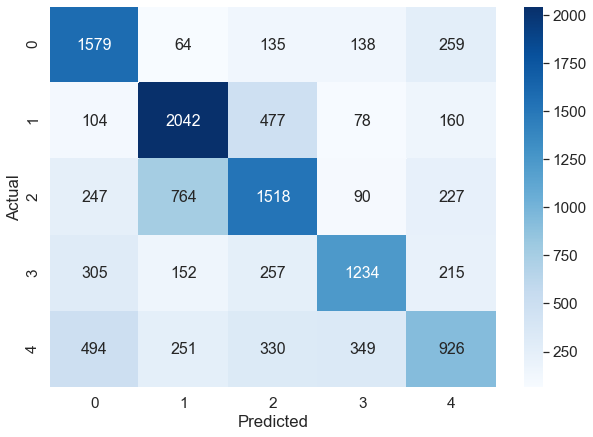

In [69]:
d = metrics.confusion_matrix(y_test, y_pred_rf)
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

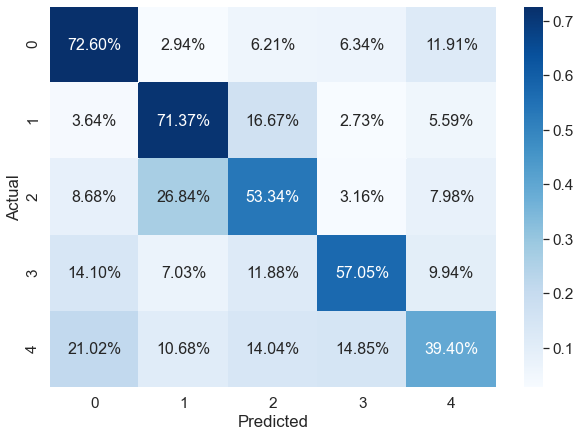

In [70]:
d = metrics.confusion_matrix(y_test, y_pred_rf,normalize = 'true')
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2%')# font size

In [67]:
print(classification_report(y_test, y_pred_rf, target_names=emotions))

              precision    recall  f1-score   support

     Neutral       0.58      0.73      0.64      2175
       Angry       0.62      0.71      0.67      2861
       Happy       0.56      0.53      0.55      2846
         Sad       0.65      0.57      0.61      2163
  Frustrated       0.52      0.39      0.45      2350

    accuracy                           0.59     12395
   macro avg       0.59      0.59      0.58     12395
weighted avg       0.59      0.59      0.58     12395



ROC AUC score (RF-Normalized): 0.7420706798858714


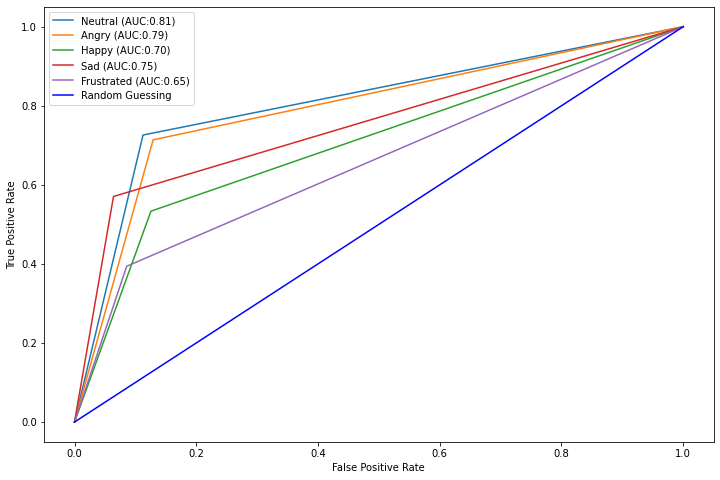

In [60]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

y_pred_mlp = best_model.predict(X_test)
y_pred_mlp = y_pred_mlp.argmax(axis=-1)
print('ROC AUC score (RF-Normalized):', multiclass_roc_auc_score(y_test, y_pred_rf))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

## MLP (Normalized)

In [29]:
y_train_ohe = keras.utils.to_categorical(y_train, 5)
y_test_ohe = keras.utils.to_categorical(y_test, 5)

In [38]:
model_nrm = Sequential()
model_nrm.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 193))
model_nrm.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))
model_nrm.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))
model_nrm.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax'))
model_nrm.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_nrm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               49664     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 91,141
Trainable params: 91,141
Non-trainable params: 0
_________________________________________________________________


In [28]:
model_nrm = Sequential()
model_nrm.add(Dense(units = 386, kernel_initializer = 'uniform', activation = 'relu', input_dim = 193))
model_nrm.add(Dense(units = 257, kernel_initializer = 'uniform', activation = 'relu'))
model_nrm.add(Dense(units = 171, kernel_initializer = 'uniform', activation = 'relu'))
#model_nrm.add(Dense(units = 114, kernel_initializer = 'uniform', activation = 'relu'))
model_nrm.add(Dense(units = 5, kernel_initializer = 'uniform', activation = 'softmax'))
model_nrm.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_nrm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 386)               74884     
_________________________________________________________________
dense_5 (Dense)              (None, 257)               99459     
_________________________________________________________________
dense_6 (Dense)              (None, 171)               44118     
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 860       
Total params: 219,321
Trainable params: 219,321
Non-trainable params: 0
_________________________________________________________________


In [39]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_ser_nrm_11.hdf5', save_best_only=True, monitor="val_accuracy", mode='max', save_weights_only=False)  

In [40]:
hist = model_nrm.fit ( X_train_normalized, y_train_ohe, validation_data=(X_test_normalized,y_test_ohe), batch_size=32, epochs=50, callbacks=[checkpoint] )

Epoch 1/50
1550/1550 [==============================] - 5s 3ms/step - loss: 1.3054 - accuracy: 0.4197 - val_loss: 1.1402 - val_accuracy: 0.5225
Epoch 2/50
1550/1550 [==============================] - 4s 3ms/step - loss: 1.1011 - accuracy: 0.5364 - val_loss: 1.0741 - val_accuracy: 0.5572
Epoch 3/50
1550/1550 [==============================] - 4s 3ms/step - loss: 1.0164 - accuracy: 0.5821 - val_loss: 1.0399 - val_accuracy: 0.5731
Epoch 4/50
1550/1550 [==============================] - 4s 3ms/step - loss: 0.9439 - accuracy: 0.6150 - val_loss: 1.0128 - val_accuracy: 0.5885
Epoch 5/50
1550/1550 [==============================] - 4s 3ms/step - loss: 0.8677 - accuracy: 0.6463 - val_loss: 0.9968 - val_accuracy: 0.5994
Epoch 6/50
1550/1550 [==============================] - 4s 3ms/step - loss: 0.8094 - accuracy: 0.6727 - val_loss: 0.9541 - val_accuracy: 0.6197
Epoch 7/50
1550/1550 [==============================] - 4s 3ms/step - loss: 0.7409 - accuracy: 0.7020 - val_loss: 0.9755 - val_accuracy:

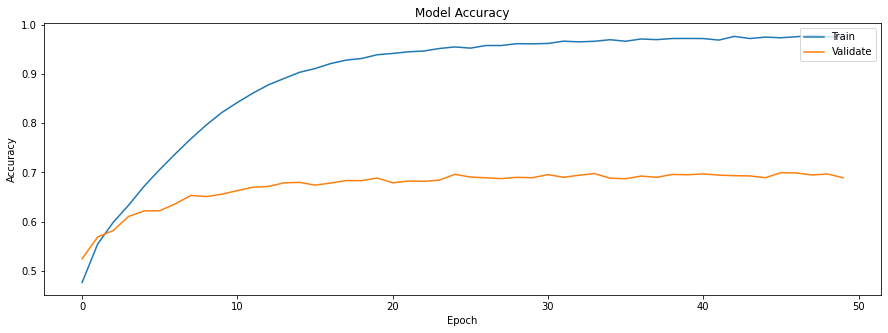

In [31]:
plt.figure(figsize=(15,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

In [41]:
# Evaluate the model from the last epoch
score = model_nrm.evaluate(X_test_normalized, y_test_ohe, verbose=0)
print('Model from the last epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Load and evaluate the model from the best epoch
best_model = load_model('model/model_ser_nrm_11.hdf5', compile=True )
score = best_model.evaluate(X_test_normalized, y_test_ohe, verbose=0)
print('Model from the best epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model from the last epoch:
Test loss: 2.0581696033477783
Test accuracy: 0.6664783954620361
Model from the best epoch:
Test loss: 1.9075466394424438
Test accuracy: 0.6755143404006958


In [ ]:
best_model = load_model('model/model_ser_nrm_07.hdf5', compile=True ) #best model: model_ser_nrm_07 ACC 0.70
score = best_model.evaluate(X_test_normalized, y_test_ohe, verbose=0)
print('Model from the best epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [28]:
best_model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_209 (Dense)            (None, 386)               74884     
_________________________________________________________________
dense_210 (Dense)            (None, 257)               99459     
_________________________________________________________________
dense_211 (Dense)            (None, 171)               44118     
_________________________________________________________________
dense_212 (Dense)            (None, 5)                 860       
Total params: 219,321
Trainable params: 219,321
Non-trainable params: 0
_________________________________________________________________


In [53]:
y_pred_mlp = best_model.predict(X_test_normalized)
y_pred_mlp = y_pred_mlp.argmax(axis=-1)
print(classification_report(y_test, y_pred_mlp, target_names=emotions))

              precision    recall  f1-score   support

     Neutral       0.70      0.76      0.73      2175
       Angry       0.75      0.76      0.75      2861
       Happy       0.70      0.70      0.70      2846
         Sad       0.70      0.76      0.73      2163
  Frustrated       0.66      0.55      0.60      2350

    accuracy                           0.71     12395
   macro avg       0.70      0.70      0.70     12395
weighted avg       0.70      0.71      0.70     12395



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

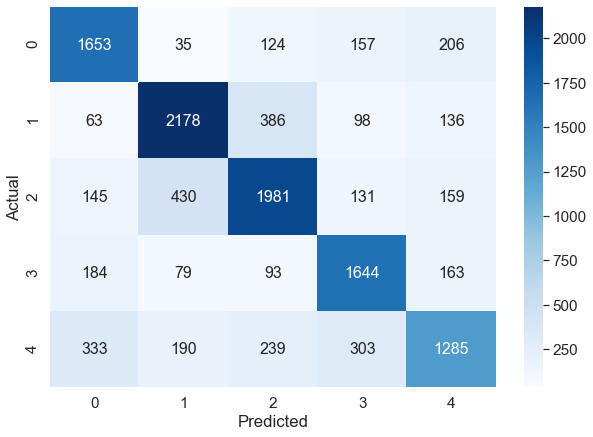

In [56]:
d = metrics.confusion_matrix(y_test, y_pred_mlp)
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

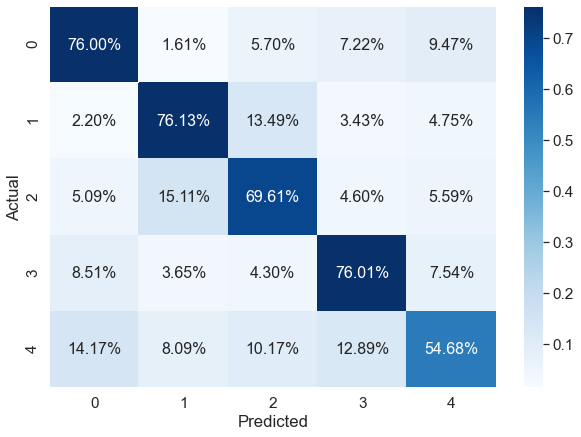

In [68]:
d = metrics.confusion_matrix(y_test, y_pred_mlp,normalize = 'true')
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2%')# font size

ROC AUC score (MLP-Normalized): 0.8154656890930039


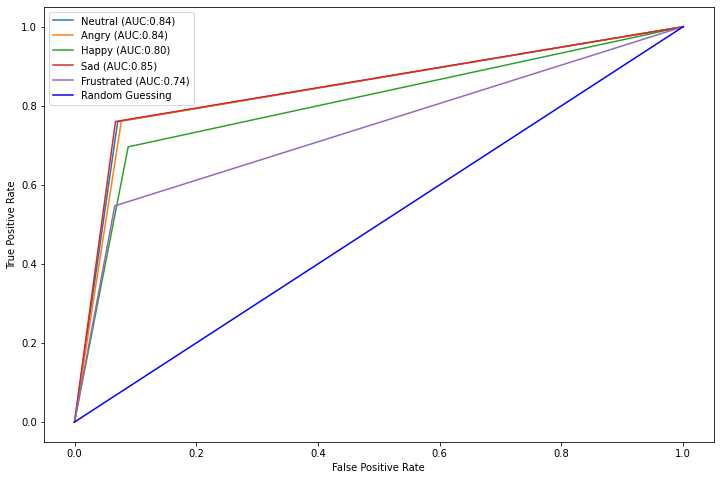

In [30]:
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(emotions):
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

y_pred_mlp = best_model.predict(X_test_normalized)
y_pred_mlp = y_pred_mlp.argmax(axis=-1)
print('ROC AUC score (MLP-Normalized):', multiclass_roc_auc_score(y_test, y_pred_mlp))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [ ]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(best_model, X_test_normalized, y_test_ohe,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [13]:
test = extract_feature('D:\\ThaiSER_V1\\src\\s044_clip_actor127_impro8_15.wav')
test1 = extract_feature('C:\\Users\\iHAVECPU\\Desktop\\demo_ser\\data\\audio.wav')
prediction = best_model.predict(sc.transform([test1]).tolist())
maxindex = int(np.argmax(prediction))
print(emotions[maxindex])

Sad


In [81]:
test

array([-2.99630341e+02,  1.68472839e+02, -6.58050823e+00, -7.36223757e-01,
       -8.13269615e+00, -1.41529989e+01,  1.02114563e+01, -5.60175657e-01,
        4.72628117e+00,  4.18265200e+00,  3.16982567e-01,  3.29684591e+00,
       -1.96434402e+00, -1.94944050e-02, -1.02239027e+01, -4.68630254e-01,
       -3.45073652e+00, -3.38517964e-01, -4.47185040e+00,  3.00617266e+00,
       -4.59379530e+00,  1.80891049e+00, -3.25070310e+00,  7.02783442e+00,
        6.36205339e+00,  1.03823080e+01,  6.84764099e+00,  6.71676731e+00,
        1.05086946e+00,  4.26214314e+00,  1.58233154e+00,  5.33693600e+00,
        1.24831796e+00,  5.32871199e+00,  2.86667204e+00,  6.61486149e+00,
        5.04831409e+00,  4.08829546e+00,  7.75461793e-01,  2.99781942e+00,
        5.31812191e-01,  5.93884230e-01,  5.74746668e-01,  4.42666709e-01,
        4.22129989e-01,  4.97946799e-01,  5.44164896e-01,  5.83156645e-01,
        5.23442209e-01,  4.59869325e-01,  4.68039215e-01,  4.80197757e-01,
        8.91534507e-01,  

## Model Conv1D

In [44]:
x_traincnn = np.expand_dims(X_train_normalized, axis= 2)
x_testcnn = np.expand_dims(X_test_normalized, axis= 2)

In [45]:
y_train_ohe = keras.utils.to_categorical(y_train, 5)
y_test_ohe = keras.utils.to_categorical(y_test, 5)

In [24]:
x_traincnn.shape

(49577, 193, 1)

In [42]:
modelconv = Sequential()

modelconv.add(Conv1D(256, 5,padding='same',input_shape=(193,1)))        #1
modelconv.add(BatchNormalization())
modelconv.add(Activation('relu'))

modelconv.add(Conv1D(128, 5,padding='same'))                           #2
modelconv.add(Activation('relu'))
modelconv.add(Dropout(0.1))

modelconv.add(MaxPooling1D(pool_size=(8)))

modelconv.add(Conv1D(128, 5,padding='same', activation='relu'))                           #3
modelconv.add(Dropout(0.2))

modelconv.add(Flatten())
modelconv.add(Dense(units = 3072, kernel_initializer = 'uniform', activation = 'relu'))
#modelconv.add(Dense(units = 1536, kernel_initializer = 'uniform', activation = 'relu'))
modelconv.add(Dense(units = 5, activation = 'softmax'))

In [43]:
opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)

In [44]:
modelconv.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [45]:
modelconv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 193, 256)          1536      
_________________________________________________________________
batch_normalization_1 (Batch (None, 193, 256)          1024      
_________________________________________________________________
activation_2 (Activation)    (None, 193, 256)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 193, 128)          163968    
_________________________________________________________________
activation_3 (Activation)    (None, 193, 128)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 193, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 128)          

In [46]:
checkpoint_cnn = tf.keras.callbacks.ModelCheckpoint('model/model_ser_cnn_1.hdf5', save_best_only=True, monitor="val_accuracy", mode='max', save_weights_only=False)  

In [47]:
hist_cnn = modelconv.fit( x_traincnn, y_train_ohe, validation_data=(x_testcnn,y_test_ohe), batch_size=32, epochs=100, callbacks=[checkpoint_cnn] )

Epoch 1/100
1550/1550 [==============================] - 20s 13ms/step - loss: 1.3837 - accuracy: 0.4156 - val_loss: 1.1950 - val_accuracy: 0.4987
Epoch 2/100
1550/1550 [==============================] - 19s 12ms/step - loss: 1.1807 - accuracy: 0.4995 - val_loss: 1.1472 - val_accuracy: 0.5232
Epoch 3/100
1550/1550 [==============================] - 19s 12ms/step - loss: 1.1292 - accuracy: 0.5306 - val_loss: 1.1113 - val_accuracy: 0.5457
Epoch 4/100
1550/1550 [==============================] - 19s 12ms/step - loss: 1.0822 - accuracy: 0.5555 - val_loss: 1.1144 - val_accuracy: 0.5422
Epoch 5/100
1550/1550 [==============================] - 19s 12ms/step - loss: 1.0422 - accuracy: 0.5764 - val_loss: 1.1238 - val_accuracy: 0.5400
Epoch 6/100
1550/1550 [==============================] - 19s 12ms/step - loss: 1.0097 - accuracy: 0.5875 - val_loss: 1.0826 - val_accuracy: 0.5520
Epoch 7/100
1550/1550 [==============================] - 19s 12ms/step - loss: 0.9721 - accuracy: 0.6073 - val_loss: 1

In [49]:
# Evaluate the model from the last epoch
score = modelconv.evaluate(x_testcnn, y_test_ohe, verbose=0)
print('Model from the last epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Load and evaluate the model from the best epoch
best_modelconv = load_model('model/model_ser_cnn_1.hdf5', compile=True )
score = best_modelconv.evaluate(x_testcnn, y_test_ohe, verbose=0)
print('Model from the best epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model from the last epoch:
Test loss: 1.3174211978912354
Test accuracy: 0.6572811603546143
Model from the best epoch:
Test loss: 1.6404902935028076
Test accuracy: 0.6659137010574341


In [58]:
best_modelconv = load_model('model/model_ser_cnn_1.hdf5', compile=True )

In [59]:
print(classification_report(y_test, y_pred_conv, target_names=emotions))

              precision    recall  f1-score   support

     Neutral       0.65      0.77      0.70      2175
       Angry       0.69      0.75      0.72      2861
       Happy       0.69      0.58      0.63      2846
         Sad       0.69      0.69      0.69      2163
  Frustrated       0.60      0.55      0.57      2350

    accuracy                           0.67     12395
   macro avg       0.66      0.67      0.66     12395
weighted avg       0.67      0.67      0.66     12395



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

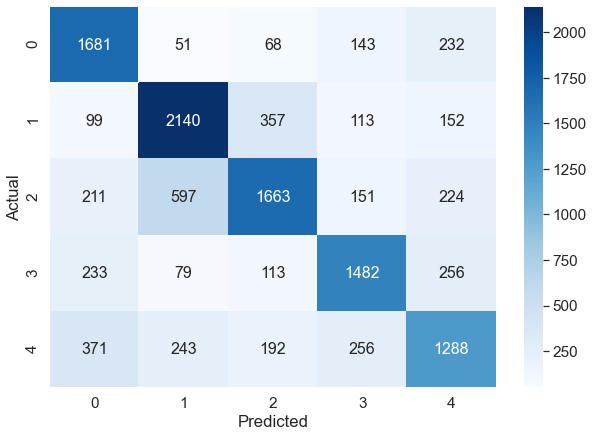

In [62]:
y_pred_conv = best_modelconv.predict(x_testcnn)
y_pred_conv = y_pred_conv.argmax(axis=-1)
d = metrics.confusion_matrix(y_test, y_pred_conv)
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='d')# font size

In [65]:
cf_matrix_test = metrics.confusion_matrix(y_test, y_pred_conv)
cf_matrix_test

array([[1681,   51,   68,  143,  232],
       [  99, 2140,  357,  113,  152],
       [ 211,  597, 1663,  151,  224],
       [ 233,   79,  113, 1482,  256],
       [ 371,  243,  192,  256, 1288]], dtype=int64)

In [66]:
np.sum(cf_matrix_test)

12395

<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

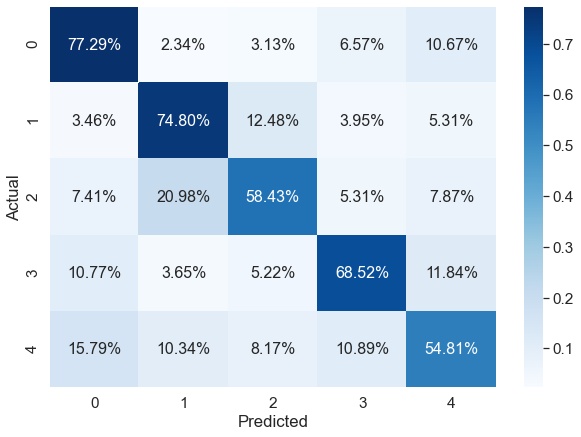

In [67]:
d = metrics.confusion_matrix(y_test, y_pred_conv,normalize = 'true')
df_cm = pd.DataFrame(d, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='.2%')# font size